# **Project 2 - Genetic Algorithm for Image Reconstruction.**
**Subject:** MC906/MO416 - Introduction to Artificial Intelligence 

**Authors:**

    Eduardo Barros Innarelli - RA 170161
    Victor Ferreira Ferrari  - RA 187890
    Vinicius Couto Espindola - RA 188115

## **Introduction**
### Project
The project consists of a study of genetic algorithm-based solutions for **image reconstruction**. A few set aspects of the problem will be explained, implemented and discussed here, such as:

- The **modeling** of the problem as an evolutionary problem (chromosomes, genes, etc);
- How to **generate the initial population**;
- The chosen **fitness function**;
- How to **visualize** the result.

Along with that, some aspects of the genetic algorithm will be tested and discussed with multiple approaches, such as:

- Stop criteria;
- Selection technique;
- Crossover technique;
- Mutation technique;
- Generation replacement method.

Also, the following **parameters** will be tested with multiple values as well:
- Population size;
- Mutation rate;
- Crossover rate.

In the end, different variations of the process will be compared and discussed.

### Usage

This project uses the external libraries _OpenCV_ for image reading and manipulation, _NumPy_ for array manipulation, _Scikit-Learn_ for error calculations, and _MatPlotLib_ for result visualization. The other imports are part of the Standard Python Library.

In [25]:
# External Libraries
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error
import numpy as np
import cv2

# Python Libraries
from random import randint, sample, uniform, shuffle

## **Problem**
### General Information
The problem consists of, given an image, recreate it from scratch, using the original image only for fitness purposes, to check the similarity between our image and the original. This is not particularly useful in many applications, but can be used as basis for other problems, and is good for the purpose of this project: test different methods of reproduction, mutation, etc.

The motivation came from [Roger Johansson's "Evolution of Mona Lisa"](https://rogerjohansson.blog/2008/12/07/genetic-programming-evolution-of-mona-lisa/), but instead of using polygons, the pixel values are directly used.

### Modeling
The modeling of the problem as a GA problem is almost direct: the image is the individual (chromosome) and each of its pixels is a gene. The image can be represented by a multitude of different ways. The chosen way of representation is as a flat array, as this allows for easier operations, especially crossover.

### Inputs
Due to the huge number of combinations in an image (255 possiblities per pixel), greyscale images are used in this project. Low-resolution images are best for this, but there are methods of reducing the resolution using _OpenCV_.

## **Methods**

### Notes on Structure

The code was organized in such a manner which allows us to first define every method used as well as discuss them in separated modules, making each part more readable and comprehesible.

In order to merge all components of the code we created a class called GeneticAlgorithm. This class retains some essential variables for the methods defined along the report. In order to allow the methods to access these variables even though they are not a part of the class, every single method must receive as it's first parameter the class instance, prepended into every parameter list.

### Population Initialization

The first step to run a genetic algorithm is creating a population to serve as a starting point for the selection, reproduction and mutation process. This function also handles the initilization of the current best population, the best population overall fitness and best individual fitness, which are paramount for convergence check and final results.   

Every method in this section will be subdued by the following parameters:
 1. **fitness:** Used to calculate to initialize population score and best individual.
 2. **pop_size:** Defines the maximum amount of individuals for the population.
 
**Note:** The amount of genes in each individual is defined by the goal variables in the class. These variables store information of the image we aim to generate, including the amount of pixels (which are the genes in our model).

The following code defines some methods which will be used to create a population out of nothing.

In [127]:
def random(self, pop_size):
    # Generate completely random indivuduals 
    self.population = []
    for i in range(pop_size):
        print(f"Generating Population...  {i:>3}/{pop_size}\r", end='')
        person = [randint(0,255) for i in range(self.goal.size)]
        person = np.asarray(person, dtype=np.uint8)
        self.population.append(person)
    print(f"{' '*50}\r", end='')

In [27]:
def heuristic(self, pop_size):
    pass

### Fitness Function
**Responsible: Victor**

For each individual, we must determine a method which will tell us how apt such individual for the problem in question.

The following methods define some method to evaluate how close is an individual to the image we seek to generate.

In [28]:
def rmse(individual, original):
     return mean_squared_error(original, individual, squared=False)

In [29]:
def mse(individual, original):
     return mean_squared_error(original, individual)

In [30]:
def mean_abs_error(individual, original):
    return mean_absolute_error(original, individual)

In [31]:
def median_abs_error(individual, original):
    return median_absolute_error(original, individual)

### Convergence Criteria

The algorithm cannot run forever. In this section will define a convergence method for halting the program's exection. 

The convergence function must identify when the algorithm's improvement rate has significantly decreased or even stalled. To do so, it must know the overall quality of the current population, which can be easily calculated with the sum of every indivudual's fitness score. Let's call this overall finess the generation fitness. We can estimate when the algorithm is decreasing it's evolution rate (or improvement rate) by checking how many generations have passed since the best generation so far was achieved: the more unimproved generations, the more likely is has converged. This is what the convergence method will do.

As a sidenote, since the convergence method must calculate every individual fitness for every new geneartion that is created, we can take advantage of this computation and update some other essential information for our genetic algorithm. Besides updating the current best generation fitness, which is necessary for the convergence check, we'll also update the current best individual found so far across all generations.

**Note:** even checking for convergence, the algorithm might still present sufficiently small improvements to avoid convergence, however, they might be so small that it will take a enormous amount of time to converge. As a failsafe to this scenario, we will limit the total amount of generations that can be created from withing the GeneticAlgorithm class.

In [173]:
def convergence(self, fitness, limit):
    ''' Identifies convergence and updates fittest individual found so far 
        
        Parameters:
            self - GeneticAlgorithm class which the function is being called from
            fitness - A function which gives the fitness of an invidual
            limit - Amount of iterations wich can be worst than the best one found so far
        Return:
            Bool - True if converged, False otherwise.
    '''
    # Get fitness average for population
    new_genfit = 0
    for person in self.population:
        fit = fitness(person, self.goal)
        new_genfit += fit
        if fit < self.best_fit: 
            self.best     = person # save best inividual
            self.best_fit = fit
            
    new_genfit /= len(self.population) # using simple mean
     
    # Update number of iterations without improvement
    if new_genfit >= self.best_genfit:
        self.counter += 1
    else:
        self.counter = 0
        self.best_genfit = new_genfit
    
    # Check convergence
    if self.counter >= limit:
        self.counter = 0
        return True
    else:
        return False 

### Parent Selection Criteria (SELECTION TECHNIQUE)

In this section we'll define methods responsible for selecting individual of the population responsible for bearing the next generation.

Every method in this section will be subdued by the following parameters:
 1. **P:** Defines the probability of accepting a certain idividual.
 2. **N:** Amount of individuals to be selected for the next generation.
 3. **K:** Amount of individuals to partake in a competition.
 
The following code defines some methods which will be used to select individual for the creation of the next generation.

In [32]:
def competition(self, P, N, K):
    pass

In [33]:
def roulette(self, P, N, K):
    pass

### Reproduction Method

Reproduction will ensure that the select individuals can exchange genes, preserving some genetic diversity for the next generation.

Every method in this section will be subdued by the following parameters:
 1. **K:** Amount of crossover points for gene exchange.
 
The following code defines some methods which will be used for reproduction to create the next generation.

In [139]:
def crosspoint(self, k):
    # Define random coulpes and some auxiliar info
    num_genes = self.goal.size
    #### NOTE:
    # this should be replaced by a proper parent selection method
    shuffle(self.population)
    mid = len(self.population)//2
    couples = zip(self.population[:mid],self.population[mid:])

        
    for father,mother in couples:
        # Save k unique random crosspoints in a sorted list
        crosspoints = sorted(sample(range(0, num_genes-1), k))

        # List of crosspoint pairs, adding a pair with last crosspoint
        # and last pixel
        # Ex: 
        # 16 pixels, points [1,9,12] -> pairs [(1,9), (9,12), (12,16)]
        pairs = list(zip(crosspoints,crosspoints[1:]))
        pairs.append(tuple((crosspoints[-1], num_genes)))

        # Perform crossover in pair range, intercalating pairs
        for start, end in pairs[::2]:
            father[start:end] = mother[start:end]
            mother[start:end] = father[start:end]

In [ ]:
def uniform_crossover(exchange_prob, parent1, parent2):
    
    num_pixels = self.goal.size
    
    # Exchange genes with a given probability
    for gene in range(num_pixels):
        if uniform(0,1) < exhange_prob:
            parent1[gene], parent2[gene] = parent2[gene], parent1[gene]
    
    return (parent1, parent2)        

### Mutation Method
**Responsible: Victor**

To simply permute the genes of the previous generation might reduce the diversity among individuals by creating childs which are too similar to their parents. To counter this we'll use mutation methods allowing genes to mix within individuals. 

Every method in this section will be subdued by the following parameters:
 1. **MR:** Mutation rate dictates the probability of an individual to mutate.
 2. **MA:** Mutation amount defines the amount of genes which will mutate.
 
The following code defines some methods which will be used to mutate the individuals.

In [35]:
def flip(pop, MR, MA):
    
    # Select individuals to mutate.
    mut_amount = int(MR*len(pop))
    individuals = np.random.choice(len(pop), mut_amount, replace=False)
    size = pop[0].size
    
    # Change elements to random value.
    gene_amount = int(MA*size)
    for i in individuals:
        genes = np.random.choice(size, gene_amount, replace=False)
        new = np.random.randint(0, 255, gene_amount)
        pop[i][genes] = new
            
    return pop

In [36]:
def swap(pop, MR, MA):
    
    # Select individuals to mutate.
    mut_amount = int(MR*len(pop))
    individuals = np.random.choice(len(pop), mut_amount, replace=False)
    size = pop[0].size
    
    # Swap genes (TODO: swap sequences?).
    gene_amount = int(MA*size)
    for i in individuals:
        genes1 = np.random.choicee(size, gene_amount, replace=False)
        genes2 = np.random.randint(size, gene_amount, replace=False)
        pop[i][[genes1,genes2]] = pop[i][[genes2,genes1]]

    return pop

### Survivor Selection (REPLACEMENT METHOD)

After selection parents, reproducing and running the mutation process, we're bound to have more individuala than before. This increase can affect the algorithms perfromance by increassing the memory usage, necessary time for each time as well as affecting the convergence rate due to unfit individual being kept alive. We mitigate this issue by applying a final step over the new generation of individuals which will define the ones who live and the ones whe die.

Every method in this section will be subdued by the following parameters:
 1. **amount_kept:** Integer which defines the amount of individuals that survive this step.
 
The following code defines some methods which will be used to select the survivors of the new population.

In [ ]:
def age(self):
    pass

In [ ]:
def fitness(self):
    pass

## **Genetic Algorithm Class**

The class will be responsible for selecting which methods will be used for each of the methods in each of the algorithms steps, as well as define it's parameters and executing the main loop. The main loop will be responsible for properly calling the methods, any in between tasks as wells as check halting conditions and picking the fittest individual found in all generations.

##### Preprocessing and Visualization Method
To perceive empirically if the quality of each generation as well as the final result, we will use openCV to exhibit the image represented by some individual.

In [174]:
class GeneticAlgorithm():
    ''' The GeneticAlgorithm class retains and coordinates a necessary variables and methods
        for the execution of the genetic algorithm created.
        It's initialization receives the methods which will compute each step of the algorithm
        as well as the parameters utilized by each of these methods. A limit integer is also
        define to halt the programs execution.
        
        Methods:
            run  - execute the genetic algorithm based on the instance variables/methods
            read - read a image from file, rescale and flatten
            show - reshape flattened image and exhibit with matplotlib
    '''
    
    def __init__(self, 
                 limit  = 10000, # Max amount of generations to create
                 conv   = None,  # Convergence function and parameters
                 init   = None,  # Population Initializer function and parameters
                 select = None,  # Population Selection function and parameters
                 reprod = None,  # Selected Indviduals Reproduction function and parameters
                 mutate = None   # Selected Indviduals Mutation function and parameters
                ):
        
        # Halting criterias
        self.counter = 0 # Convergence counter
        self.limit = limit
        self.abort = lambda: bool(self.gen_count >= self.limit)
        # TODO: Add time criteria
        
        # Goal related variables
        self.shape = None # Holds original downsized image shape
        self.goal  = None # Holds an array with the ideal individual (goal image)
        
        # Convergence related variables
        self.best        = None         # Best individual obtained so far
        self.best_fit    = float('inf') # The fit score of the bets individual so far
        self.best_genfit = float('inf') # Overall fitness of the fittest population
        
        # Generation related variables
        self.population = None  # List of individual of the current generation
        self.gen_count  = 1     # Current generation (first, second, ...)
        
        # Static Genetic Methods Functions
        define = lambda x: lambda: x[0](self,*x[1]) if x[0] else None
        self.conv   = define(conv)
        self.init   = define(init)
        self.select = define(select)
        self.reprod = define(reprod)
        self.mutate = define(mutate)
        
        test = [self.conv,self.init,self.select,self.reprod,self.mutate]
        test = all(map(bool, test))
        assert test, "There are undefined steps for the algorithm"
    
    def test(self, img_path):
        self.read(img_path, res=0.6)
        self.init()
        
        while not (self.conv() or self.abort()):
            print(f"Current Generation: {self.gen_count:>5}\r", end='')
            
            #############
            # Run Steps #
            #############
            
            self.gen_count += 1
            continue
            
        self.counter = 0
        self.show(self.best, compare=True)
    
    def read(self, filepath, res=None):
        '''Reads an image in grey scale, resizes it and extends to array.
            Params:
                filepath - Path to the input image to be read
                res - Either tuple with new pixel dimensions or ratio with new scale
            Return: 
                np.array - array with the streched image
        '''
        img = cv2.imread(filepath,0) # load in greyscale
        
        if res and tuple==type(res):
            img = cv2.resize(img, res)
        elif res and float==type(res):
            w = int(img.shape[0]*res)
            h = int(img.shape[1]*res)
            img = cv2.resize(img, (h,w))
            
        self.shape = img.shape # keep shape
        self.goal  = img.reshape(img.size)

    def show(self, individual, compare=False):
        '''Prints the image represented by an individual.
            Params:
                individual - Np.array to be reshaped and printed
        '''
        plt.figure(figsize=(15,15))
        
        # If compare mode, print goal along side
        if compare: 
            plt.subplot(1,2,2)
            goal = self.goal.copy()
            goal = goal.reshape(self.shape)
            plt.imshow(goal, cmap='gray')
            plt.title('Goal')
            plt.axis('off')
            plt.subplot(1,2,1)
            
        img = individual.copy()
        img = img.reshape(self.shape)
        plt.imshow(img, cmap='gray')
        plt.title('Individual')
        plt.axis('off')
        plt.show()    

105.31301993067592 105.31301993067592             
105.31301993067592 105.31301993067592
105.31301993067592 105.31301993067592
105.31301993067592 105.31301993067592
105.31301993067592 105.31301993067592
105.31301993067592 105.31301993067592
105.31301993067592 105.31301993067592
105.31301993067592 105.31301993067592
105.31301993067592 105.31301993067592
105.31301993067592 105.31301993067592
105.31301993067592 105.31301993067592
105.31301993067592 105.31301993067592
105.31301993067592 105.31301993067592
105.31301993067592 105.31301993067592
105.31301993067592 105.31301993067592
105.31301993067592 105.31301993067592
105.31301993067592 105.31301993067592
105.31301993067592 105.31301993067592
105.31301993067592 105.31301993067592
105.31301993067592 105.31301993067592
105.31301993067592 105.31301993067592
105.31301993067592 105.31301993067592
105.31301993067592 105.31301993067592
105.31301993067592 105.31301993067592
105.31301993067592 105.31301993067592
105.31301993067592 105.31301993067592

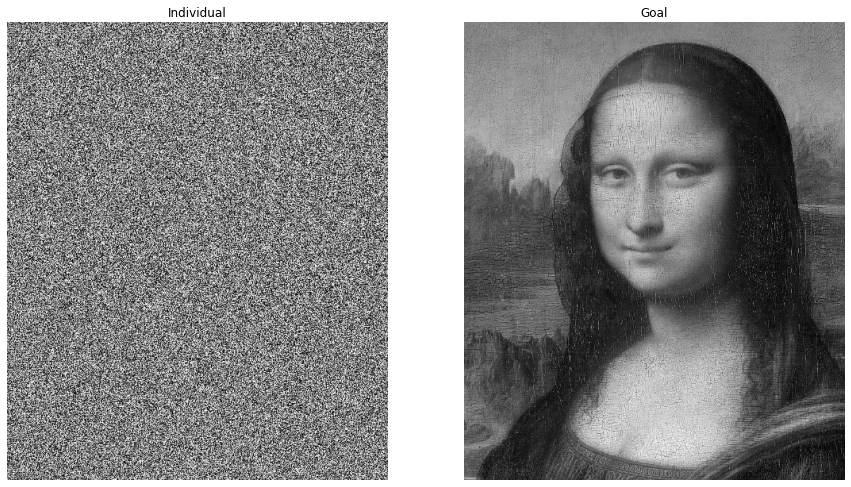

In [175]:
ga = GeneticAlgorithm(
    conv   = (convergence,(mse,150)), 
    init   = (random,[3]),
    select = (roulette,[None]), 
    reprod = (crosspoint,[None]), 
    mutate = (flip,[None])
    )

ga.test('images\monalisa.jpg')

In [ ]:
#     def run(self, filename):
#         goal = self.read()
#         pop = gen_initial_population(POP_SIZE)
    
#         # Fitness
#         fit = []
#         for i in pop:
#             fit.append(fitness(i))
#         fit = np.array(fit)

#         # Best
#         best_idx = np.argmax(fit)
#         best_sol = pop[best_idx]
#         best_val = fit[best_idx]

#         # Stop criteria
#         sol_val = np.arange(N).sum()
#         iterations = 0

#         while best_val < sol_val and iterations < MAX_ITER:

#             # Roulette selection
#             sel = selection(pop, fit, POP_SIZE)

#             # Reproduction
#             for i in range(0, len(sel), 2):
#                 pop[i], pop[i+1] = reproduction(sel[i], sel[i+1])

#             # Mutation
#             mutate_pop(pop, MUT_RATE)

#             # Fitness
#             for i in range(POP_SIZE):
#                 fit[i] = fitness(pop[i])

#             # Update Max
#             best_idx = np.argmax(fit)
#             if fit[best_idx] > best_val:
#                 best_sol = pop[best_idx]
#                 best_val = fit[best_idx]

#             iterations += 1

#         # Board
#         board = create_board(best_sol)
#         print(board)

#         print('Solution: ', best_sol)
#         print('Iterations: ', iterations)
#         print('Solution Value: ', best_val)

## **Tests**

## **Result Analysis and Comparisons**

## **Conclusions**